<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-model" data-toc-modified-id="The-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The model</a></span></li></ul></div>

In [1]:
import numpy as np
import sympy as sp
import numba as nb
import matplotlib.pyplot as plt

## The model

Simple model in three equations:

$$\begin{align} \frac{C_{t+1}}{C_t} &= \beta(\alpha e^{A_{t+1}} K_{t+1}^{\alpha - 1} + 1 - \delta) \\
                K_{t+1} &= e^{A_t} K_t^\alpha + (1 - \delta) K_t - C_t \\
                A_t &= \rho A_{t-1} \end{align}$$
                
With steady state:

$$\begin{align} A_{ss} &= 0 \\
                K_{ss} &= \frac{1 - \beta (1- \delta)}{\beta\alpha} \\
                C_{ss} &= K_{ss}^\alpha - \delta K_{ss} \end{align}$$

In [2]:
@nb.njit
def f(K, A, alpha=0.33):
    return np.exp(A) * K ** alpha

@nb.njit
def f_prime(K, A, alpha=0.33):
    return alpha * np.exp(A) * K ** (alpha - 1)

@nb.njit
def u_prime(C):
    return 1 / C

@nb.njit
def u_prime_inv(C):
    return 1 / C

@nb.njit
def step_system(A, K, C, alpha=0.33, beta=0.99, delta=0.035, rho=0.95):
    next_A = rho * A
    next_K = f(K, A, alpha) + (1 - delta) * K - C
    next_C = u_prime_inv(u_prime(C) / (beta * (f_prime(next_K, next_A, alpha) + (1 - delta))))
    
    return next_A, next_K, next_C

@nb.njit
def steady_state(alpha=0.33, beta=0.99, delta=0.035, rho=0.95):
    A_ss = 0
    K_ss = ((1 - beta * (1 - delta)) / alpha / beta) ** (1 / (alpha - 1))
    C_ss = f(K_ss, A_ss, alpha) - delta * K_ss
    
    return A_ss, K_ss, C_ss

In [3]:
@nb.njit
def line_one(K, alpha=0.33, delta=0.035):
    return K ** alpha - delta * K

@nb.njit
def line_two(K, alpha=0.33, beta=0.99, delta=0.035, rho=0.95):
    A_ss, K_ss, C_ss = steady_state(alpha, beta, delta, rho)
    return K ** alpha + (1 - delta) * K - K_ss

In [4]:
@nb.njit
def simulate_model(k0, c0, A=0, alpha=0.33, beta=0.99, delta=0.035, rho=0.95, T=10):
    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+1)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        _, k_vec[t+1], c_vec[t+1] = step_system(A, k_vec[t], c_vec[t], alpha, beta, delta, rho)

    return k_vec, c_vec

@nb.njit
def bisect_solve_trajectory(c0, k0, k_target=0, A=0, alpha=0.33, beta=0.99, delta=0.035, rho=0.95, 
                            T=100, max_iter=1000, tol=1e-8, verbose=True):
    
    upper_bound = f(k0, A, alpha)
    lower_bound = 0
    
    for i in range(max_iter):
        k_trajectory, c_trajectory = simulate_model(k0, c0, A, alpha, beta, delta, rho, T)
        error = k_trajectory[-1] - k_target
        if abs(error) < tol:
            if verbose:
                print(f'Converged on iteration {i}')
            return c_trajectory, k_trajectory
            
        if error > 0:
            lower_bound = c0
        else:
            upper_bound = c0
        
        c0 = (upper_bound + lower_bound) / 2
    
    if verbose:
        print('Algorithm failed to converge')
    return c_trajectory, k_trajectory

In [5]:
from matplotlib import colors
def vector_to_rgb(angle, absolute):
    global max_abs

    angle = angle % (2 * np.pi)
    if angle < 0:
        angle += 2 * np.pi

    return colors.hsv_to_rgb((angle / 2 / np.pi, 
                                         absolute / max_abs, 
                                         absolute / max_abs))

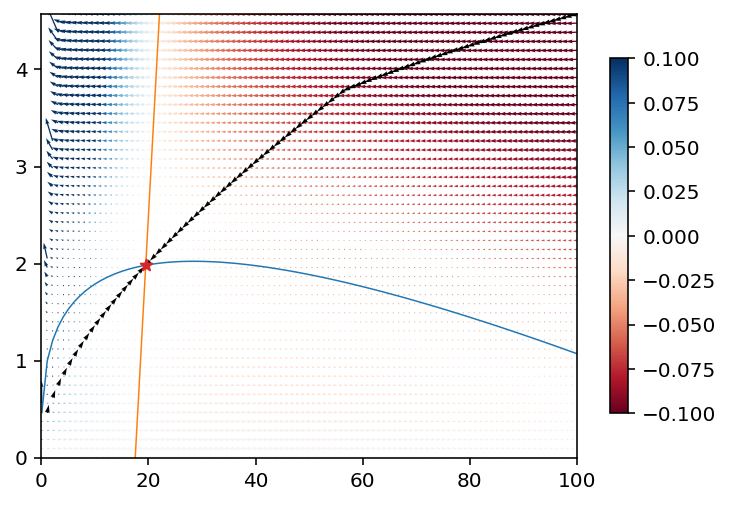

In [6]:
k_grid = np.linspace(0.1, 100, 100)
c_grid = np.linspace(0, f(100, 0))

kk, cc = np.meshgrid(k_grid, c_grid)
_, next_kk, next_cc = step_system(0, kk, cc)
delta_kk = next_kk - kk
delta_cc = next_cc - cc

fig, ax = plt.subplots(figsize=(6, 4), dpi=144)
quiver_plot = ax.quiver(kk, cc, delta_kk, delta_cc, delta_cc, clim=(-0.1, 0.1), cmap=plt.cm.RdBu)
ax.plot(k_grid, line_one(k_grid), lw=0.75)
ax.plot(k_grid, line_two(k_grid), lw=0.75)
ax.set_ylim(0, f(100, 0))
ax.set_xlim(0, 100)
fig.colorbar(quiver_plot, shrink=0.8)

_, k_ss, c_ss = steady_state()

saddle_c = np.empty_like(k_grid)
for i, k in enumerate(k_grid):
    c_star, _ = bisect_solve_trajectory(f(k, 0), k, k_target=k_ss, T=100, max_iter=10_000, verbose=False)
    saddle_c[i] = c_star[0]

delta_k = np.empty_like(k_grid)
delta_c = np.empty_like(saddle_c)

initial_point = (17, 3)
k_traj, c_traj = simulate_model(*initial_point, T=500)
delta_k = k_grid[1:] - k_grid[:-1]
delta_c = saddle_c[1:] - saddle_c[:-1]

delta_k[k_grid[1:] > k_ss] = -1 * delta_k[k_grid[1:] > k_ss]
delta_c[saddle_c[1:] > c_ss] = -1 * delta_c[saddle_c[1:] > c_ss]

plt.quiver(k_grid[1:], saddle_c[1:], delta_k, delta_c, angles='xy', scale=70, color='k')
ax.scatter(k_ss, c_ss, marker='*', color='tab:red', zorder=10)

plt.show()

In [7]:
@nb.njit
def system_errors(X, alpha=0.33, beta=0.99, delta=0.035, rho=0.95):
    A, K, C, A_next, K_next, C_next = X
    A_error = A_next - rho * A
    K_error = K_next - f(K, A, alpha) + (1 - delta) * K - C
    C_error = C_next - u_prime_inv(u_prime(C) / (beta * (f_prime(K_next, A_next, alpha) + (1 - delta))))
    
    return sum([A_error, K_error, C_error])

@nb.njit
def total_error(Y_flat, x0, x_final, alpha=0.33, beta=0.99, delta=0.035, rho=0.95):
    Y = Y_flat.reshape((-1, x0.shape[0]))
    Y_augmented = np.vstack((np.atleast_2d(x0), Y, np.atleast_2d(x_final)))
    Y_lag = np.hstack((Y_augmented[1:], Y_augmented[:-1]))
    
    T, k = Y_lag.shape
    errors = np.zeros(T)
    for t in range(T):
        errors[t] = system_errors(Y_lag[t], alpha, beta, delta, rho)
    return errors.sum()
    

In [8]:
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol

In [9]:
def _numpycode(self, *args, **kwargs):
    return self.safe_name

setattr(TimeAwareSymbol, '_numpycode', _numpycode)

In [307]:
from typing import List, Optional, Union, Callable
import re
ZERO_PATTERN = re.compile(r"(?<![\.\w])0([ ,\]])")

def numba_lambdify(
    exog_vars: List[sp.Symbol],
    expr: Union[List[sp.Expr], sp.Matrix, List[sp.Matrix]],
    endog_vars: Optional[List[sp.Symbol]] = None,
    func_signature: Optional[str] = None,
) -> Callable:
    """
    Convert a sympy expression into a Numba-compiled function.  Unlike sp.lambdify, the resulting function can be
    pickled. In addition, common sub-expressions are gathered using sp.cse and assigned to local variables,
    giving a (very) modest performance boost. A signature can optionally be provided for numba.njit.

    Finally, the resulting function always returns a numpy array, rather than a list.

    Parameters
    ----------
    exog_vars: list of sympy.Symbol
        A list of "exogenous" variables. The distinction between "exogenous" and "enodgenous" is
        useful when passing the resulting function to a scipy.optimize optimizer. In this context, exogenous
        variables should be the choice varibles used to minimize the function.
    expr : list of sympy.Expr or sp.Matrix
        The sympy expression(s) to be converted. Expects a list of expressions (in the case that we're compiling a
        system to be stacked into a single output vector), a single matrix (which is returned as a single nd-array)
        or a list of matrices (which are returned as a list of nd-arrays)
    endog_vars : Optional, list of sympy.Symbol
        A list of "exogenous" variables, passed as a second argument to the function.
    func_signature: str
        A numba function signature, passed to the numba.njit decorator on the generated function.

    Returns
    -------
    numba.types.function
        A Numba-compiled function equivalent to the input expression.

    Notes
    -----
    The function returned by this function is pickleable.
    """

    FLOAT_SUBS = {
        sp.core.numbers.One(): sp.Float(1),
        sp.core.numbers.NegativeOne(): sp.Float(-1),
    }

    if func_signature is None:
        decorator = "@nb.njit"
    else:
        decorator = f"@nb.njit({func_signature})"

    len_checks = []
    len_checks.append(
        f'    assert len(exog_inputs) == {len(exog_vars)}, "Expected {len(exog_vars)} exog_inputs"'
    )
    if endog_vars is not None:
        len_checks.append(
            f'    assert len(endog_inputs) == {len(endog_vars)}, "Expected {len(endog_vars)} exog_inputs"'
        )
    len_checks = "\n".join(len_checks)

    # Special case: expr is [[]]. This can occur if no user-defined steady-state values were provided.
    # It shouldn't happen otherwise.
    if expr == [[]]:
        sub_dict = ()
        code = ""
        retvals = ["[None]"]

    else:
        # Need to make the float substitutions so that numba can correctly interpret everything, but we have to handle
        # several cases:
        # Case 1: expr is just a single Sympy thing
        if isinstance(expr, (sp.Matrix, sp.SparseMatrix, sp.Expr)):
            expr = expr.subs(FLOAT_SUBS)

        # Case 2: expr is a list. Items in the list are either lists of expressions (systems of equations),
        # single equations, or matrices.
        elif isinstance(expr, list):
            new_expr = []
            for item in expr:
                # Case 2a: It's a simple list of sympy things
                if isinstance(item, (sp.Matrix, sp.Expr)):
                    new_expr.append(item.subs(FLOAT_SUBS))
                # Case 2b: It's a system of equations, List[List[sp.Expr]]
                elif isinstance(item, list):
                    if all([isinstance(x, (sp.Matrix, sp.SparseMatrix, sp.Expr)) for x in item]):
                        new_expr.append([x.subs(FLOAT_SUBS) for x in item])
                    else:
                        raise ValueError("Unexpected input type for expr")
            expr = new_expr
        else:
            raise ValueError("Unexpected input type for expr")

        sub_dict, expr = sp.cse(expr)

        # Converting matrices to a list of lists is convenient because NumPyPrinter() won't wrap them in np.array
#         exprs = []
#         for ex in expr:
#             if hasattr(ex, "tolist"):
#                 exprs.append(ex.tolist())
#             else:
#                 exprs.append(ex)
        exprs = expr
        codes = []
        retvals = []
        
        for i, expr in enumerate(exprs):
            code_name = f"retval_{i}"
            retvals.append(code_name)

            if not isinstance(expr, sp.SparseMatrix):
                code = sp.printing.numpy.NumPyPrinter().doprint(expr)
                delimiter = "]," if "]," in code else ","
                code = code.split(delimiter)
                code = [" " * 8 + eq.strip() for eq in code]
                code = f"{delimiter}\n".join(code)
                code = code.replace("numpy.", "np.")

                # Handle conversion of 0 to 0.0
                code = re.sub(ZERO_PATTERN, r"0.0\g<1>", code)

                code = f"    {code_name} = {code}"
                codes.append(code)
        code = "\n".join(codes)

    input_signature = "exog_inputs"
    unpacked_inputs = "\n".join(
        [f"    {getattr(x, 'safe_name', x.name)} = exog_inputs[{i}]" for i, x in enumerate(exog_vars)]
    )
    if endog_vars is not None:
        input_signature += ", endog_inputs"
        exog_unpacked = "\n".join(
            [f"    {getattr(x, 'safe_name', x.name)} = endog_inputs[{i}]" for i, x in enumerate(endog_vars)]
        )
        unpacked_inputs += "\n" + exog_unpacked

    assignments = "\n".join(
        [
            f"    {x} = {sp.printing.numpy.NumPyPrinter().doprint(y).replace('numpy.', 'np.')}"
            for x, y in sub_dict
        ]
    )
    
    sparse_code = []
    for i, expr in enumerate(exprs):
        if isinstance(expr, sp.SparseMatrix):
            indices = np.array(list(expr.todok().keys()))    
            datas = list(expr.todok().values())
            
            data_strs = [sp.printing.numpy.NumPyPrinter().doprint(data).replace('numpy.', 'np.') for data in datas]
            data_str = 'sparse_data = [' + ', '.join(data_strs) + ']'
            
            s_ind = str(indices)
            s_ind = re.sub('\n', ' ', s_ind)
            s_ind = re.sub(' +', ' ', s_ind)
            s_ind = re.sub('\[ ', '[', s_ind)
            s_ind = re.sub(' ', ', ', s_ind)
            s_ind = f'indices = np.array({s_ind})'
            loop_str = f"n, k = {expr.shape[0]}, {expr.shape[1]}\n    retval_{i} = np.zeros((n, k))\n\n"
            loop_str += '    for idx, data in zip(indices, sparse_data):\n'
            loop_str += f'        retval_{i}[idx[0], idx[1]] = data'
            
            sparse_code.append(f'    {s_ind}\n    {data_str}\n    {loop_str}')
    
    sparse_generation_code = '\n'.join(sparse_code) if len(sparse_code) > 0 else ''
#     return_var_list = '[' + ', '.join(return_var_list) + ']'
    returns = f'[{",".join(retvals)}]' #if len(retvals) > 1 else retvals[0]
    full_code = f"{decorator}\ndef f({input_signature}):\n{unpacked_inputs}\n\n{assignments}\n\n{code}{sparse_generation_code}\n\n    return {returns}"

    docstring = f"'''Automatically generated code:\n{full_code}'''"
    code = f"{decorator}\ndef f({input_signature}):\n    {docstring}\n{len_checks}\n{unpacked_inputs}\n\n{assignments}\n\n{code}{sparse_generation_code}\n\n    return {returns}"
        
    exec(code)
    return locals()["f"]


def step_equation_to(eq, t):
    to_step = []

    for variable in set(eq.atoms()):
        if hasattr(variable, "step_forward"):
            if variable.time_index != "ss":
                to_step.append(variable)

    for variable in sorted(to_step, key=lambda x: x.time_index, reverse=True):
        eq = eq.subs({variable: variable.set_t(t + variable.time_index)})
    
    return eq

In [355]:
A = TimeAwareSymbol('A', 0)
K = TimeAwareSymbol('K', 0)
C = TimeAwareSymbol('C', 0)

alpha, beta, delta, rho = sp.symbols('alpha beta delta rho')

eq1 = A.step_forward() - rho * A
eq2 = K.step_forward() - K ** alpha - (1 - delta) * K + C 
eq3 = C.step_forward() / C - beta * (alpha * K.step_forward() ** (alpha - 1) + 1 - delta)

In [371]:
from functools import reduce
from gEconpy.shared.utilities import step_equation_forward
# from gEconpy.numba_tools.utilities import numba_lambdify
var_stack = reduce(lambda a, b: a + b, [[K.set_t(i), C.set_t(i)] for i in range(51)])

eq_stack = []
y0 = np.zeros(len(var_stack))
for i, var in enumerate(var_stack):
    time_idx = var.time_index
    name = var.base_name
    if name == 'C':
        eq = step_equation_to(eq3.subs({A:0, A.set_t(1):0}), time_idx)
        y0[i] = c_ss
    if name == 'K':
        eq = step_equation_to(eq2.subs({A:0, A.set_t(1):0}), time_idx)
        y0[i] = k_ss
    eq_stack.append(eq)
    
jac_mat = sp.SparseMatrix([[eq.diff(x) for x in var_stack[1:-1]] for eq in eq_stack[:-2]])

In [372]:
f_mat = numba_lambdify(exog_vars=var_stack[1:-1], endog_vars=[K, C.set_t(50), alpha, beta, delta, rho], expr=jac_mat)
f_error = numba_lambdify(exog_vars=var_stack[1:-1], endog_vars=[K, C.set_t(50), alpha, beta, delta, rho], expr=sp.Matrix(eq_stack[:-2]))

In [373]:
from scipy import sparse
i = 0
lr = 1e-2
y = y0[:-2].copy()
while True:
    A_mat_val = f_mat(y, np.array([k_ss / 2, c_ss, 0.33, 0.99, 0.035, 0.99]))[0]
    F_y = f_error(y, np.array([k_ss / 2, c_ss, 0.33, 0.99, 0.035, 0.99]))[0].ravel()
    F_jac_inv = np.linalg.inv(A_mat_val)
    
    next_y = y - lr * (F_jac_inv @ F_y)
    loss = np.max(abs(y - next_y))
    if loss < 1e-12 or np.isnan(loss):
        break
    
    y = next_y
    i += 1
    if i % 100 == 0:
        print(loss)

0.2070291086800644
0.14595842187211616
0.08466637660120924
0.0364091300255005
0.014064133183236294
0.005244044504145506
0.0019321449680447245
0.0007089101519035523
0.0002597088055473762
9.509190213563556e-05
3.4810740018542674e-05
1.274239631854357e-05
4.664201455284456e-06
1.7072582636501465e-06
6.249130386493107e-07
2.2873855698435364e-07
8.372573390147409e-08
3.064632991822691e-08
1.1217547779551751e-08
4.1059848854274605e-09
1.50292223111137e-09
5.501199495938636e-10
2.013607058870548e-10
7.370459798039519e-11
2.6979307676811004e-11
9.876544027065393e-12
3.6131098113401094e-12
1.3216094885137863e-12


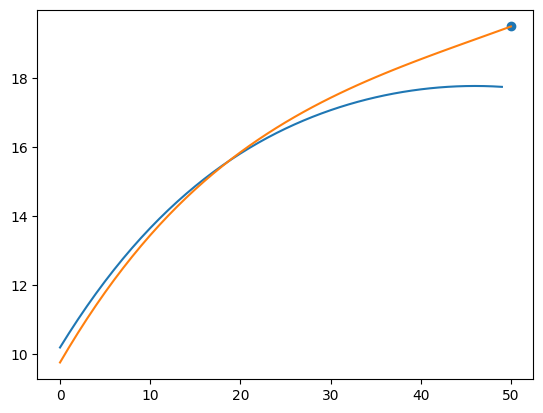

In [374]:
c_star, k_star = bisect_solve_trajectory(0.3, k_ss / 2, k_target=k_ss, T=50, max_iter=10_000, verbose=False)

plt.plot(y.reshape(-1,2)[:, 1])
plt.plot(k_star)
plt.scatter(50, k_ss)

In [104]:
def f_optim(x, *args):
    x0, x_last, *params = args
    
    inputs = np.r_[x0, x, x_last, params]
    error = f_error(*inputs)[3:-3]
    
    return error

def f_jac_optim(x, *args):
    x0, x_last, *params = args
    
    inputs = np.r_[x0, x, x_last, params]
    jac = f_mat(*inputs).todense()
    return jac[3:-3, 3:-3]
    

In [105]:
from scipy import optimize
x0 = np.array([[0, k_ss, c_ss]] * 48).ravel()
x_init = np.array([0.5, k_ss * 0.5, 0.3])
x_final = np.array([0, k_ss, c_ss])

res = optimize.root(f_optim, 
                        x0=x0, 
                        args=(x_init, x_final, 0.33, 0.99, 0.035, 0.95), 
                        jac=f_jac_optim,
                        method='lm')

In [106]:
res

 message: The relative error between two consecutive iterates is at most 0.000000
 success: True
  status: 2
     fun: [ 0.000e+00  2.220e-16 ...  2.220e-16  0.000e+00]
       x: [ 0.000e+00  1.950e+01 ...  1.950e+01  1.983e+00]
   cov_x: [[ 1.401e+03 -1.167e+05 ... -3.258e+01 -1.699e-11]
           [-1.167e+05  1.026e+07 ...  3.388e+03  9.973e+01]
           ...
           [-3.258e+01  3.388e+03 ...  9.674e+00  9.900e-01]
           [-1.699e-11  9.973e+01 ...  9.900e-01  1.000e+00]]
    nfev: 2
    njev: 1
    fjac: [[-3.002e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00 -3.002e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ... -8.373e-03  9.735e-01]
           [ 0.000e+00  0.000e+00 ...  2.564e-03  3.122e-04]]
    ipvt: [ 4 10 ... 47  2]
     qtf: [ 1.971e-16  1.971e-16 ...  2.869e-17 -6.913e-18]

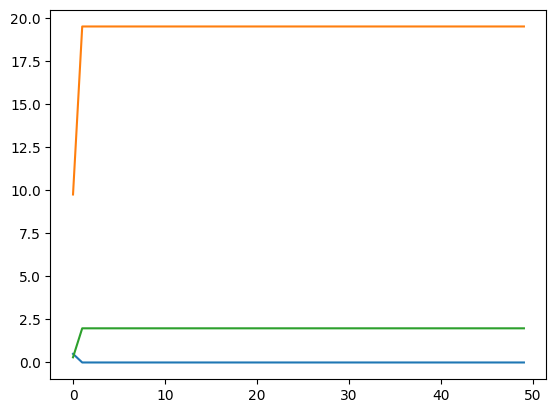

In [107]:
plt.plot(np.r_[[x_init], res.x.reshape(-1, 3), [x_final]])

In [109]:
import pytensor
import pytensor.tensor as pt

In [376]:
Y0 = np.array([[0, k_ss, c_ss]] * 50).ravel()
Y = pytensor.shared(Y0, name='Y')

x0 = pt.dvector('x0')
x_target = pt.dvector('x_target')

alpha = pt.dscalar('alpha')
beta = pt.dscalar('beta')
delta = pt.dscalar('delta')
rho = pt.dscalar('rho')

Y_aug = pt.concatenate([pt.atleast_2d(x0), Y.reshape((-1, 3)), pt.atleast_2d(x_target)], axis=0)
Y_lag = pt.concatenate([Y_aug[:-1], Y_aug[1:]], axis=1).T

def f(K, A, alpha):
    return pt.exp(A) * K ** alpha

def f_prime(K, A, alpha):
    return pt.exp(A) * alpha * K ** (alpha - 1)

def u_prime(C):
    return 1 / C

def u_prime_inv(C):
    return 1 / C

A_t = Y_lag[0]
K_t = Y_lag[1]
C_t = Y_lag[2]
A_tp1 = Y_lag[3]
K_tp1 = Y_lag[4]
C_tp1 = Y_lag[5]

A_error = A_tp1 - rho * A_t
K_error = K_tp1 - f(K_t, A_t, alpha) - (1 - delta) * K_t + C_t
C_error = C_tp1 - u_prime_inv(u_prime(C_t) / (beta * (f_prime(K_tp1, A_tp1, alpha) + (1 - delta))))

errors = pt.stack([A_error, K_error, C_error]).T.ravel()
error_jac_list = pytensor.gradient.jacobian(errors, [Y, x_target])
error_jac = pt.concatenate(error_jac_list, axis=1)
jac_inv = pt.linalg.inv(error_jac)

learning_rate = pt.dscalar('learning_rate')
newton_update = Y - learning_rate * (jac_inv @ errors)[:-3]

In [377]:
# f_error = pytensor.function([x0, x_target, alpha, beta, delta, rho], [errors])
# f_grad = pytensor.function([Y, x0, x_target, alpha, beta, delta, rho, T, k], [error_grad])
# f_jac_inv  = pytensor.function([x0, x_target, alpha, beta, delta, rho], [jac_inv])

newton_step = pytensor.function([x0, x_target, alpha, beta, delta, rho, learning_rate],
                                [error_jac], 
                                updates=[(Y, newton_update)],
                                on_unused_input='ignore')

In [380]:
with np.printoptions(linewidth=10000, precision=3, suppress=True):
    print(newton_step(x0_val, x_target_val, 0.33, 0.99, 0.035, 0.95, 1)[0][:10, :10])

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.019  0.001  1.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.95   0.     0.     1.     0.     0.     0.     0.     0.     0.   ]
 [-2.221 -1.03   1.     0.     1.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.015 -0.018  0.001  1.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.95   0.     0.     1.     0.     0.     0.   ]
 [ 0.     0.     0.    -2.317 -1.025  1.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -1.01  -0.017  0.001  1.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.95   0.     0.     1.   ]]


In [387]:
jac_mat[:10, :10]

Matrix([
[-alpha*K_t**alpha*exp(A_t)/K_t + delta - 1,                                                       1,                                                               1,                                                       0,                                                                 0,                                                       0,                                                                 0,                                                       0,                                                                 0,                                                       0],
[                                         0, -beta*(alpha*K_t+1**(alpha - 1)*exp(A_t+1) - delta + 1), -alpha*beta*C_t*K_t+1**(alpha - 1)*(alpha - 1)*exp(A_t+1)/K_t+1,                                                       1,                                                                 0,                                                       0,                                               

In [357]:
x0_val = np.array([0, k_ss / 2, 0.3])
Y0 = np.array([[0, k_ss, c_ss]] * 49).ravel()
x_target_val = np.array([0, k_ss, c_ss])

Y.set_value(Y0)
# newton_step(x0_val, x_target_val, 0.33, 0.99, 0.035, 0.95, 1)[0].shape

(51, 3)

In [361]:
last_y = newton_step(x0_val, x_target_val, 0.33, 0.99, 0.035, 0.95, 1)[0]
i = 0
while True:
    next_y = newton_step(x0_val, x_target_val, 0.33, 0.99, 0.035, 0.95, 1e-2)[0]
    loss = np.max(np.abs(last_y - next_y)) 
    if i % 100 == 0:
        print(loss)
    if loss < 1e-8 or np.isnan(loss):
        break
    last_y = next_y.copy()
    i += 1

1.4210854715202004e-14


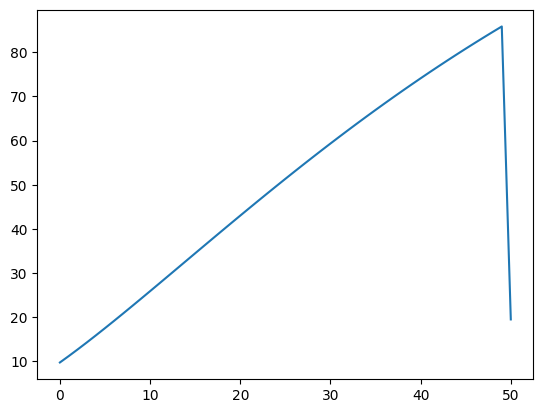

In [364]:
plt.plot(last_y[:, 1])

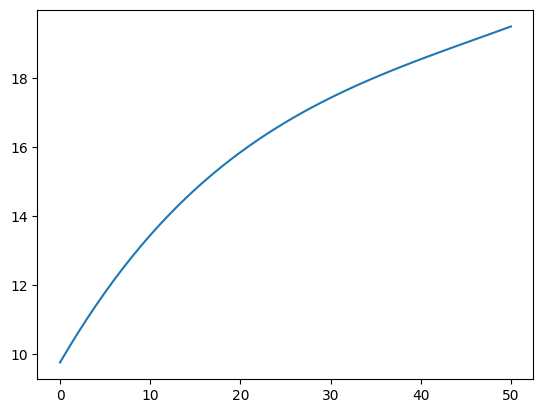